Piotr Karaś

# AGH Modelling of Physical Systems Lab 4 (2025 March 25th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl)

**1. diffusion PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   

Transport of $\color{green}\psi$ due to diffusion with consant coefficient $\color{orange}\mu$ can be modelled with the diffusion equation:
$$ \partial_{\color{red} t} {\color{green}\psi} - {\color{orange}\mu} \partial^2_{\color{blue}x}{\color{green}\psi}= 0 $$

For the special case of domain of length $L$ and initial condition ${\color{green}\psi}({\color{red} t}=0,{\color{blue}x}) = \sin(\pi {\color{blue}x} / L)$, an analytical solution is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=e^{-\mu (\pi/L)^2 {\color{red} t}} \sin(\pi {\color{blue}x} / L)$$

Let's depict the problem using NumPy and matplotlib:

In [11]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

In [12]:
class PsiAnalytic:
    def __init__(self, *, mu, L):
        self.mu = mu
        self.L = L

    def __call__(self, *, x, t):
        return np.exp(-self.mu * t * (np.pi / self.L) ** 2) * np.sin(np.pi * x / self.L)

In [13]:
psi_analytic = PsiAnalytic(mu=.5, L=10)
nx = 64
x, dx = np.linspace(0, psi_analytic.L, nx + 1, endpoint=True, retstep=True)
x = x[:-1] + dx / 2
t_max = 10

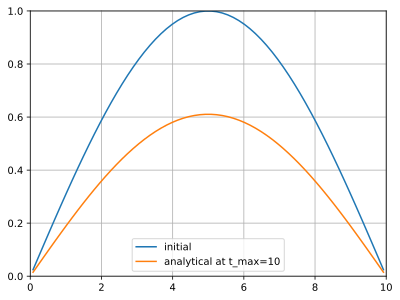

In [14]:
pyplot.plot(x, psi_analytic(x=x, t=0), label='initial')
pyplot.plot(x, psi_analytic(x=x, t=t_max), label=f'analytical at {t_max=}')
pyplot.xlim(0, psi_analytic.L)
pyplot.ylim(0, 1)
pyplot.legend()
pyplot.grid()
show_plot('analytic.pdf')

**2. overview of applications**

* diffusion of heat
* diffusion of pollutants in atmosphere and hydrosphere
* diffusion of moisture away from evaporating rain drops
* diffusion in PDE originating from SDE in mathematical finance (market volatility)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

Diffusion can be expressed in terms of advective fluxes:

$$ \partial_t {\color{green}\psi} +\partial_x \big(\, \underbrace{-\mu \frac{\partial_x {\color{green}\psi}}{{\color{green}\psi}}}_{u} \psi \big) = 0$$

hence we can leverage the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver to numerically integrate the diffusion equation: 

* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   


$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C_{i+1/2}^{\color{red}n}}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C_{i-1/2}^{\color{red}n}}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

with:

$$C_{{\color{blue}i}-1/2}=\frac{\Delta t}{\Delta x}u_{{\color{blue}i}-1/2}=-\mu\frac{\Delta t}{\Delta x}\frac{{\color{green}\psi}_{\color{blue}i}-{\color{green}\psi}_{{\color{blue}i}-1}}{\Delta x}\frac{2}{{\color{green}\psi}_{{\color{blue}i}}+{\color{green}\psi}_{{\color{blue}i}-1}}$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [15]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
        .5 * (C - abs(C)) * psi_r


class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)

    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [16]:
one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

nt = 600
dt = t_max / nt

i = slice(1, nx - 1)
im = slice(1, nx)

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [17]:
psi = psi_analytic(x=x, t=0)
C = np.zeros(len(psi) - 1)
output = [psi.copy()]
for _ in range(nt):
    C[im - hlf] = -2 * psi_analytic.mu * dt / dx ** 2 * (psi[im] - psi[im - one]) / (psi[im - one] + psi[im])
    assert max(abs(C)) <= 1
    psi[i] = psi[i] - (
        F(psi[i], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i], C[i - hlf])
    )
    output += [psi.copy()]

**7. comparing analytic and numerical solutions**

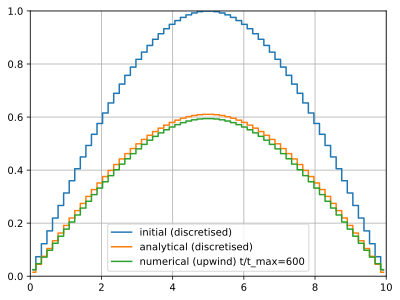

In [18]:
def plot(step):
    fig = pyplot.figure()
    pyplot.step(x, psi_analytic(x=x, t=0), label='initial (discretised)', where='mid')
    pyplot.step(x, psi_analytic(x=x, t=step * dt), label='analytical (discretised)', where='mid')
    pyplot.step(x, output[step], label=f'numerical (upwind) t/t_max={step}', where='mid')
    pyplot.legend()
    pyplot.grid()
    pyplot.xlim(0, psi_analytic.L)
    pyplot.ylim(0, 1)
    return fig


plot(nt)
show_plot('numeric.pdf')

**8. animation**


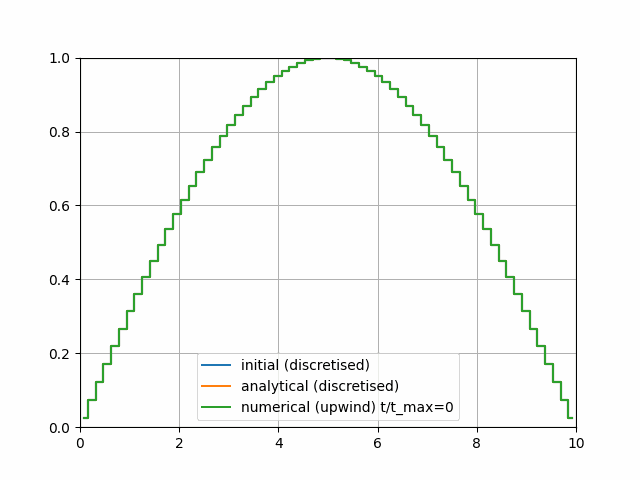

HTML(value="<a href='./tmpb6qr2lny.gif' target='_blank'>./tmpb6qr2lny.gif</a><br>")

In [19]:
show_anim(plot, range(0, nt, 3))

# Assignment

In [148]:
M = 0.05
D = 0.05
u = 1

x_min = -2
x_max = 30
nx = 600
dx = (x_max - x_min) / nx
x = np.linspace(x_min, x_max, nx, endpoint=False)

t_start = 0.1
t_end = 15.0
nt = 2000
dt = (t_end - t_start) / nt

## Analitical solution

In [149]:
def calculate_analytical(x: np.ndarray, t: float, M: float, D: float, u: float) -> np.ndarray:
    return M / np.sqrt(4 * np.pi * D * t) * np.exp(- (x - u * t) ** 2 / (4 * D * t))

psi_init = calculate_analytical(x, t_start, M, D, u)

## Numerical solution

In [150]:
psi = psi_init.copy()
C = np.zeros(len(psi) - 1)
output = [psi.copy()]
i = slice(1, nx - 1)
im = slice(1, nx)
eps = 1e-10
for index in range(nt + 1):
    C[im - hlf] = dt / dx * (u - 2.0 * D / dx * (psi[im] - psi[im - one]) / (psi[im] + psi[im - one] + eps))
    psi[i] -= F(psi[i], psi[i + one], C[i + hlf]) - F(psi[i - one], psi[i], C[i - hlf])
    output += [psi.copy()]

## Comparison between both solutions

In [158]:
def calculate_rmse(predictions: np.ndarray, targets: np.ndarray) -> float:
    return np.sqrt(np.mean((predictions - targets) ** 2))

In [159]:
def calculate_comparison(step: int) -> tuple[np.ndarray, np.ndarray, float]:
    analytical_solution = calculate_analytical(x, t_start + step * dt, M, D, u)
    numerical_solution = output[step]
    rsme = calculate_rmse(analytical_solution, numerical_solution)
    return analytical_solution, numerical_solution, rsme

In [160]:
def plot_comparison(
    analytical_solution: np.ndarray,
	numerical_solution: np.ndarray,
) -> pyplot.Figure:
    fig = pyplot.figure()
    pyplot.plot(x, analytical_solution, label='analytical solution')
    pyplot.plot(x, numerical_solution, label='numerical solution')
    pyplot.legend()
    pyplot.grid()
    return fig

0.0006572165800623715


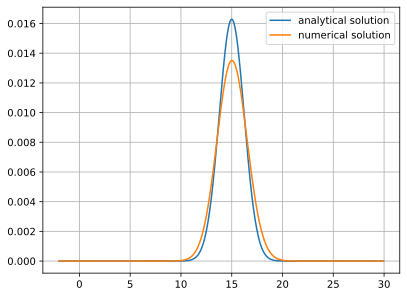

In [176]:
analytical, numerical, rmse = calculate_comparison(nt)
print(rmse)
comparison_plot = plot_comparison(analytical, numerical)
show_plot()


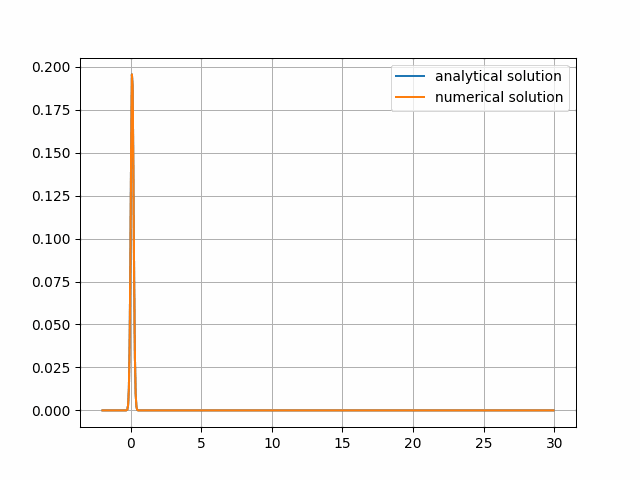

HTML(value="<a href='./tmpjj691pqj.gif' target='_blank'>./tmpjj691pqj.gif</a><br>")

In [174]:
times = np.arange(0, nt, 10)
calculated_solutions = {step: calculate_comparison(step) for step in times}

def show_one_plot(analytical_solution, numerical_solution, _) -> pyplot.Figure:
	return plot_comparison(analytical_solution, numerical_solution)

show_anim(lambda step: show_one_plot(*calculated_solutions[step]), times)

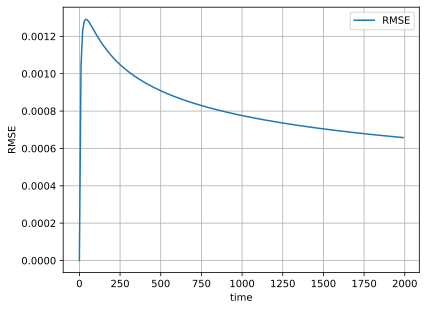

In [177]:
rmses = [calculated_solutions[step][2] for step in times]
pyplot.plot(times, rmses, label='RMSE')
pyplot.xlabel('time')
pyplot.ylabel('RMSE')
pyplot.legend()
pyplot.grid()
show_plot()

## Conclusions

- **RMSE Behavior:**
  - The RMSE shows a rapid increase initially, suggesting that early numerical approximations may introduce a transient error.
  - After reaching a peak, the RMSE decreases slowly. This pattern could indicate that once the solution adjusts to the underlying dynamics, the numerical method damps out some of the initial errors.

- **Numerical Accuracy:**
  - Despite the RMSE spike, the numerical solution remains very accurate overall when compared to the analytical solution.
  - The convergence of the numerical solution toward the analytical profile, even after the initial transient error, confirms that the chosen finite-difference scheme is robust and effective for this advection–diffusion problem.

